In [1]:
exec(open("init_notebook.py", "r").read())

current working dir/home/abjawad/Documents/GitHub/multi-region-attention


In [2]:
import os
import torch
import numpy as np
import torch.distributed as dist
from torchvision import datasets, transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import Mixup
from timm.data import create_transform
from matplotlib import pyplot as plt
from dataloader.imagenet.samplers import SubsetRandomSampler

from datasets import load_dataset
from dataloader.imagenet.HFDataset import HFDataset

In [3]:

def build_loader(config):
    # config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    # config.freeze()
    # print(f"local rank {config.LOCAL_RANK} / global rank {dist.get_rank()} successfully build train dataset")
    dataset_val, _ = build_dataset(is_train=False, config=config)
    # print(f"local rank {config.LOCAL_RANK} / global rank {dist.get_rank()} successfully build val dataset")

    # num_tasks = dist.get_world_size()
    # global_rank = dist.get_rank()
    num_tasks = 4
    global_rank = 0
    if config.DATASET.ZIP_MODE and config.DATASET.CACHE_MODE == 'part':
        indices = np.arange(dist.get_rank(), len(dataset_train), dist.get_world_size())
        sampler_train = SubsetRandomSampler(indices)
    else:
        sampler_train = torch.utils.data.DistributedSampler(
            dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
        )

    # indices = np.arange(dist.get_rank(), len(dataset_val), dist.get_world_size())
    indices = np.arange(global_rank, len(dataset_val), num_tasks)
    sampler_val = SubsetRandomSampler(indices)

    # data_loader_train = torch.utils.data.DataLoader(
    #     dataset_train, sampler=sampler_train,
    #     batch_size=config.DATASET.BATCH_SIZE,
    #     num_workers=config.DATASET.NUM_WORKERS,
    #     pin_memory=config.DATASET.PIN_MEMORY,
    #     drop_last=True,
    # )

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.DATASET.BATCH_SIZE,
        shuffle=False,  # Set shuffle to False
        num_workers=config.DATASET.NUM_WORKERS,
        pin_memory=config.DATASET.PIN_MEMORY,
        drop_last=True,
    )


    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATASET.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATASET.NUM_WORKERS,
        pin_memory=config.DATASET.PIN_MEMORY,
        drop_last=False
    )
    print("dataloader completed")

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.DATASET.NUM_CLASSES)

    return dataset_train, dataset_val, data_loader_train, data_loader_val, mixup_fn

def build_dataset(is_train, config):
    transform = build_transform(is_train, config)
    hf_dataset = load_dataset("imagenet-1k")

    print("hf dataset: ", hf_dataset)
    if is_train:
        hf_dataset = hf_dataset['train']
    else:
        hf_dataset = hf_dataset['validation']
    # Wrap Hugging Face dataset with PyTorch Dataset to apply transformations
    dataset = HFDataset(hf_dataset, transform=transform)

    nb_classes = 1000  # Number of classes for ImageNet
    return dataset, nb_classes

def build_transform(is_train, config):
    resize_im = config.DATASET.IMG_SIZE > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=config.DATASET.IMG_SIZE,
            is_training=True,
            color_jitter=config.AUG.COLOR_JITTER if config.AUG.COLOR_JITTER > 0 else None,
            auto_augment=config.AUG.AUTO_AUGMENT if config.AUG.AUTO_AUGMENT != 'none' else None,
            re_prob=config.AUG.REPROB,
            re_mode=config.AUG.REMODE,
            re_count=config.AUG.RECOUNT,
            interpolation=config.DATASET.INTERPOLATION,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(config.DATASET.IMG_SIZE, padding=4)
        return transform

    t = []
    if resize_im:
        if config.TEST.CROP:
            size = int((256 / 224) * config.DATASET.IMG_SIZE)
            t.append(
                transforms.Resize(size)
                # transforms.Resize(size, interpolation=_pil_interp(config.DATASET.INTERPOLATION)),
            )
            t.append(transforms.CenterCrop(config.DATASET.IMG_SIZE))
        else:
            t.append(
                transforms.Resize((config.DATASET.IMG_SIZE, config.DATASET.IMG_SIZE))
            )

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)


In [4]:
from configs.config_imagenet import config

dataset_train, dataset_val, data_loader_train, data_loader_val, mixup_fn = build_loader(config)
print(f"\n #training:{len(dataset_train)} #val:{len(dataset_val)}")
print(f"\n it in one epoch: len_dl::: train:{len(data_loader_train)} val:{len(data_loader_val)}")
print(f"\n batch size:{config.DATASET.BATCH_SIZE} \n")

Found cached dataset imagenet-1k (/home/abjawad/.cache/huggingface/datasets/imagenet-1k/default/1.0.0/09dbb3153f1ac686bac1f40d24f307c383b383bc171f2df5d9e91c1ad57455b9)


  0%|          | 0/3 [00:00<?, ?it/s]

hf dataset:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})


Found cached dataset imagenet-1k (/home/abjawad/.cache/huggingface/datasets/imagenet-1k/default/1.0.0/09dbb3153f1ac686bac1f40d24f307c383b383bc171f2df5d9e91c1ad57455b9)


  0%|          | 0/3 [00:00<?, ?it/s]

hf dataset:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})
dataloader completed

 #training:1281167 #val:50000

 it in one epoch: len_dl::: train:12811 val:125

 batch size:100 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx: <class 'int'> 
 samples: <class 'torch.Tensor'> 
 targets: <class 'torch.Tensor'>
idx: 0 
 samples: torch.Size([100, 3, 224, 224]) 
 targets: torch.Size([100])


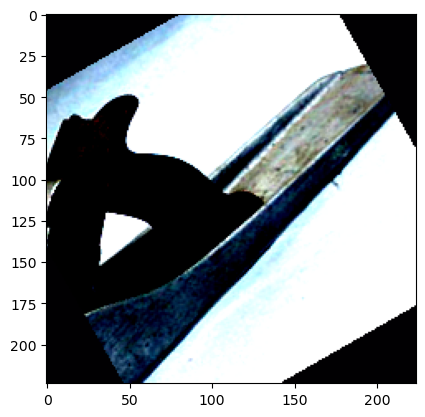

In [5]:
# Assuming you're inside the for loop of your data_loader
for idx, (samples, targets) in enumerate(data_loader_train):
    print(f"idx: {type(idx)} \n samples: {type(samples)} \n targets: {type(targets)}")
    print(f"idx: {idx} \n samples: {samples.shape} \n targets: {targets.shape}")

    # Select the first image from the batch
    image_tensor = samples[0]
    # Convert the tensor to PIL Image for displaying
    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    # Convert the tensor to a NumPy array
    image_numpy = image_tensor.numpy()

    # Display the image
    plt.imshow(image_numpy)
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx: <class 'int'> 
 samples: <class 'torch.Tensor'> 
 targets: <class 'torch.Tensor'>
idx: 0 
 samples: torch.Size([100, 3, 224, 224]) 
 targets: torch.Size([100])


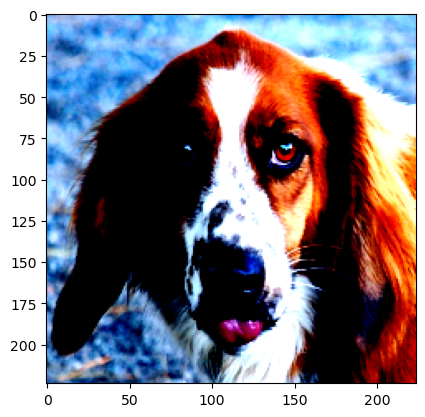

In [6]:
# Assuming you're inside the for loop of your data_loader
for idx, (samples, targets) in enumerate(data_loader_val):
    print(f"idx: {type(idx)} \n samples: {type(samples)} \n targets: {type(targets)}")
    print(f"idx: {idx} \n samples: {samples.shape} \n targets: {targets.shape}")

    # Select the first image from the batch
    image_tensor = samples[0]
    # Convert the tensor to PIL Image for displaying
    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    # Convert the tensor to a NumPy array
    image_numpy = image_tensor.numpy()

    # Display the image
    plt.imshow(image_numpy)
    plt.show()
    break